In [ ]:
%conda create -n py37gpu python=3.7 anaconda


In [1]:
pip install tensorflow

In [ ]:
import tensorflow as tf
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

In [2]:
# Работа с массивами данных
import numpy as np

# Работа с таблицами
import pandas as pd

# Основные слои
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization

# Оптимизаторы для обучения модели
from tensorflow.keras.optimizers import Adam

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Загрузка сохраненной модели
from tensorflow.keras.models import load_model

# Готовые датасеты
from tensorflow.keras.datasets import mnist, fashion_mnist

# Коллбэки для выдачи информации в процессе обучения
from tensorflow.keras.callbacks import LambdaCallback

# класс для использования Functional API
from tensorflow.keras import Model

# Отрисовка изображения
from tensorflow.keras.preprocessing import image

# Разбиение на тренировочную и тестовую выборки
from sklearn.model_selection import train_test_split 

# Функция среднеквадратической ошибки для расчетов вручную
from sklearn.metrics import mean_squared_error

# Функции операционной системы
import os

# Работа со временем
import time

# Отрисовка графиков
import matplotlib.pyplot as plt 
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import os
# Работа со временем
import time
from scipy.ndimage import zoom
import random
IMG_HEIGHT, IMG_WIDTH = 512, 128 ## todo
VAL_SPLIT = 0.1

In [3]:
IMG_HEIGHT, IMG_WIDTH = 512, 128 ## todo
VAL_SPLIT = 0.1

## Загружаем датасет

In [4]:
folder = 'dataset/'
# os.listdir(folder)

['000001.in',
 '000001_geometry.in',
 '000002.in',
 '000002_geometry.in',
 '000003.in',
 '000003_geometry.in',
 '000004.in',
 '000004_geometry.in',
 '000005.in',
 '000005_geometry.in',
 '000006.in',
 '000006_geometry.in',
 '000007.in',
 '000007_geometry.in',
 '000008.in',
 '000008_geometry.in',
 '000009.in',
 '000009_geometry.in',
 '000010.in',
 '000010_geometry.in',
 '000011.in',
 '000011_geometry.in',
 '000012.in',
 '000012_geometry.in',
 '000013.in',
 '000013_geometry.in',
 '000014.in',
 '000014_geometry.in',
 '000015.in',
 '000015_geometry.in',
 '000016.in',
 '000016_geometry.in',
 '000017.in',
 '000017_geometry.in',
 '000018.in',
 '000018_geometry.in',
 '000019.in',
 '000019_geometry.in',
 '000020.in',
 '000020_geometry.in',
 '000021.in',
 '000021_geometry.in',
 '000022.in',
 '000022_geometry.in',
 '000023.in',
 '000023_geometry.in',
 '000024.in',
 '000024_geometry.in',
 '000025.in',
 '000025_geometry.in',
 '000026.in',
 '000026_geometry.in',
 '000027.in',
 '000027_geometry.in',
 

In [5]:
def load_bscans(folder, height, width): 
    bscans_list = []                       # Список для радарограмм
    geometry_list = []
    for bscan in os.listdir(folder):        # Перебор по именам файлов в папке
        # Добавление в список изображения в виде массива,
        # в заданных размерах и в оттенках серого
        if 'bscan_' in bscan:
            bscans_list.append(zoom(np.load(os.path.join(folder, bscan)), (1,0.25)).T)
            # print(folder+'\\'+bscan)
            geom_name=f'geom{bscan[5:-4]}.npy'
            geom_np = np.load(os.path.join(folder, geom_name))
            new_geom = np.zeros((128, 128, 2),)
            new_geom[:,:,0] = 6 # наиболее часто встречающееся число
            new_geom[:,:,1] = 1 # наиболее часто встречающееся число
            new_geom[:126,:125,:2] = geom_np
            
            geometry_list.append(new_geom)
                
            
    # Возврат массива-результата
    return np.array(bscans_list), np.array(geometry_list)

# Загрузка датасета в память
cur_time = time.time()
data_bscans, data_geometry = load_bscans(folder, IMG_HEIGHT, IMG_WIDTH)
print(f'Время загрузки: {round(time.time()-cur_time)} с.')
data_bscans = data_bscans.reshape([data_bscans.shape[0], 
                                   data_bscans.shape[1], 
                                   data_bscans.shape[2], 
                                   1])
data_geometry = data_geometry[:,:,:,0].reshape([data_bscans.shape[0], 
                                   data_bscans.shape[1], 
                                   data_bscans.shape[2], 
                                   1])

Время загрузки: 3 с.


In [6]:
data_bscans.shape, data_geometry.shape

((867, 128, 128, 1), (867, 128, 128, 1))

167
(128, 128, 1)


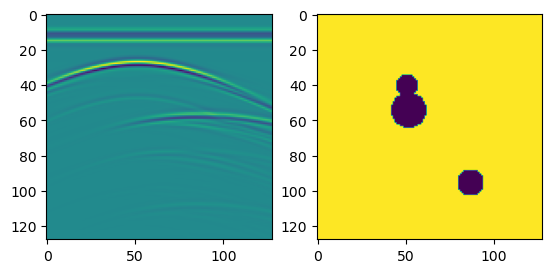

In [7]:
rand = random.randint(1, len(data_bscans)-1)
print(rand)
bscan = data_bscans[rand]
geom = data_geometry[rand]
print(geom.shape)


fig, ax = plt.subplots(1, 2)
ax[0].imshow(bscan[:, :])
ax[1].imshow(geom[:, :])
# ax[2].imshow(geom[:, :, 1])
# ax[1].imshow(npy[:, :, 1])
plt.show()
        # plt.close()

In [8]:
data_bscans = data_bscans.astype('float32') / 255.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    data_bscans, data_geometry, 
    test_size=VAL_SPLIT, 
    random_state=42)

## Нейронка

In [10]:
# Функция сборки свёрточного автокодировщика
def create_base_ae(in_shape):

  # Входной слой 
  inputs = Input(in_shape)

  # Энкодер
  # ---------------------------------------------------------------

  # 3 блока свертки перед сжатием 
  x = Conv2D(12, 3, padding='same', activation='relu')(inputs)
  x = BatchNormalization()(x)

  # используем разрежение (dilation_rate) для выявления мелких деталей изображения
  x = Conv2D(24, 3, dilation_rate=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(48, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # Сжатие 1
  x = Conv2D(96, 3, strides=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(96, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # Сжатие 2
  x = Conv2D(128, 3, strides=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(256, 3, padding='same', activation='relu')(x)

  # Скрытое пространство
  z = BatchNormalization()(x)

  # Декодер
  # ---------------------------------------------------------------
  # Расширение 2
  x = Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(z)
  x = BatchNormalization()(x)

  x = Conv2D(128, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # Расширение 1
  x = Conv2DTranspose(96, 3, strides=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(48, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(24, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(8, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # финальный слой свертки, выход модели
  outputs = Conv2D(1, 2, dilation_rate=2, padding='same', activation='sigmoid')(x)

  # Сборка модели. На входе оригинальное изображение, на выходе - сжатое-восстановленное
  model = Model(inputs, outputs)

  # компиляция модели
  model.compile(optimizer=Adam(1e-4),
                loss='mse')

  return model

In [11]:
# Функция последовательного вывода нескольких изображений для сравнения
def plot_images(target_images, noised_images, pred, shape=None, n=4): 
    if shape is None:                               # Автоопределение формы данных
        shape = target_images.shape[1:3]                   # форма изображения 

    plt.figure(figsize=(n*4, n*4), dpi=100)                     # Размер полотна
    plt.subplots_adjust(hspace=0.2, wspace=0.001)

    for i in range(0, n):                              # Повтор n раз:
        index = np.random.randint(0, pred.shape[0]) # Выбор случайного индекса 

        # Показ картинки с индексом index из оригинального набора
        ax = plt.subplot(n, 4, 4*i + 1)               # Картинка располагается в верхнем ряду
        plt.imshow(target_images[index].reshape(shape), cmap='gray')
        ax.get_xaxis().set_visible(False) 
        ax.get_yaxis().set_visible(False)
        ax.set_title('Оригинал')

        # Показ шумовой картинки с тем же индексом
        ax = plt.subplot(n, 4, 4*i + 2)           # Картинка располагается в среднем ряду
        plt.imshow(noised_images[index].reshape(shape), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title('Зашумлённое изображение')

        # Показ картинки с тем же индексом из предсказания автокодировщика
        ax = plt.subplot(n, 4, 4*i + 3)           # Картинка располагается в нижнем ряду
        plt.imshow(pred[index].reshape(shape), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title('Предсказание')

        # Показ разницы предсказания и зашумленной картинки
        ax = plt.subplot(n, 4, 4*i + 4)           # Картинка располагается в нижнем ряду
        plt.imshow(noised_images[index].reshape(shape) - pred[index].reshape(shape),
                   cmap='gray', vmin=0, vmax=1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title('Извлечённый шум')
    
    plt.show()

In [12]:
# Функция поиска оптимального порога
# На входе - mse на верном наборе и наборе выбросов,
# количество шагов порога и указание, показывать график или нет
def find_optimal_threshold(err_true, err_wrong, points=1000, factor = 2., show=True):
    # Сетка порогов между средней и кратной максимальной ошибками с малым шагом
    thresholds = np.linspace(err_true.mean(), factor * err_true.max(), points)
    
    # Массив значений ошибок для каждого значения порога
    errors_true = np.empty(thresholds.shape)
    errors_wrong = np.empty(thresholds.shape)
    errors_overall = np.empty(thresholds.shape)

    # Расчет ошибок на верных и неверных данных, общей ошибки
    # для каждого порога, и занесение ошибок в массивы
    for i in range(thresholds.shape[0]):
        errors_true[i] = 1 - (err_true < thresholds[i]).mean()
        errors_wrong[i] = (err_wrong < thresholds[i]).mean()
        errors_overall[i] = errors_true[i] + errors_wrong[i]
        
    # Определение индекса оптимального порога по минимальной общей ошибке
    optimal_i = np.argmin(errors_overall)

    # Если требуется, вывод картинки и статистик
    if show:
        plt.figure(figsize=(14,7))
        plt.plot(thresholds, errors_true, label='На верных данных')
        plt.plot(thresholds, errors_wrong, label='На выбросах')
        plt.plot(thresholds, errors_overall, label='Общая ошибка')
        plt.plot(thresholds[optimal_i], errors_overall[optimal_i], 'ro')
        plt.xlabel('Порог')
        plt.ylabel('Ошибки')
        plt.legend()
        plt.title('График ошибок при разных порогах')
        plt.show()

        print('Оптимальный порог: {:.4f}'.format(thresholds[optimal_i]))
        print('Распознано как норма на верных данных: {:.2f}%'.format(100 * (1 - errors_true[optimal_i])))
        print('Распознано как норма на выбросах     : {:.2f}%'.format(100 * errors_wrong[optimal_i]))
        print('Суммарная ошибка: {:.2f}%'.format(100 * errors_overall[optimal_i]))

    # Возврат оптимальных значений: индекс, значение порога и все ошибки
    return optimal_i, \
           thresholds[optimal_i], \
           errors_true[optimal_i], \
           errors_wrong[optimal_i], \
           errors_overall[optimal_i]

In [13]:
IMG_HEIGHT = 128                          # Высота изображений
IMG_WIDTH = 128  

## Обучение

In [14]:
# Создание автокодировщика
ae_faces = create_base_ae(X_train.shape[1:])

In [15]:
# Отображение модели
utils.plot_model(ae_faces, show_shapes=True, dpi=70)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [ ]:
# Обучение модели на датасете лиц
ae_faces.fit(X_train, y_train,
             epochs=50, 
             batch_size=1,
             validation_data=(X_test, y_test))

Epoch 1/50
